In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from utils import running_max
from bo_agent import BOAgent

In [2]:
# define files
path = "./BO/"
files = {}

# custom mean
n_epochs = [5]  # correlated models
mean_configs = {  # prior mean configurations
    "ConstantMean": [
        "None",
    ],
    "CustomMean": [
        "None",
    ],
#     "CorrelationThreshold": [
#         "None",
#     ],
#     "CorrelatedFlatten": [
#         "None", "w_offset=0.05", "w_offset=0.10", "w_offset=0.20", "w_offset=0.30", "w_offset=0.40"
#     ],
    "CorrelatedFlatten": [
        "w_offset=0.20",
    ],
#     "TrainableFlatten": [
#         "None",
#     ],
#     "Flatten": [
#         "None", "step_range=0-20", "step_range=4-5", "step_range=9-10", "step_range=10-20"
#     ],
    "Flatten": [
        "None",
    ],
#     "OccasionalConstant": [
#         "prob=0.80",
#     ],
}

for mean_class, mean_kwargs_list in mean_configs.items():
    files[mean_class] = {}
    for mean_kwargs in mean_kwargs_list:
        files[mean_class][mean_kwargs] = {}
        if mean_class == "ConstantMean":
            files[mean_class][mean_kwargs]["None"] = path + "ConstantMean/constant.pt"
        else:        
            for n_epoch in n_epochs:
                if mean_kwargs == "None":
                    files[mean_class][mean_kwargs]["{}ep".format(n_epoch)] = path + "{}/{}ep.pt".format(
                        mean_class, n_epoch)
                else:
                    files[mean_class][mean_kwargs]["{}ep".format(n_epoch)] = path + "{}/{}/{}ep.pt".format(
                        mean_class, mean_kwargs, n_epoch)

In [3]:
# load data
data = {}
for mean_class in files.keys():
    data[mean_class] = {}
    for mean_kwargs in files[mean_class].keys():
        data[mean_class][mean_kwargs] = {}
        for n_epoch_str in files[mean_class][mean_kwargs].keys():
            data[mean_class][mean_kwargs][n_epoch_str] = torch.load(
                files[mean_class][mean_kwargs][n_epoch_str])

correlations = torch.load("corr_models/correlations.pt")
maes = torch.load("corr_models/maes.pt") * 1e3  # in mm

In [4]:
# define plot function
confidence_level = 0.9
q = (1 - confidence_level) / 2.0

metric_label_lookup = {
    "mae_prior": "MAE between Ground Truth and Prior (mm)",
    "mae_posterior": "MAE between Ground Truth and Posterior (mm)",
    "mae_samples": "MAE between Samples and Prior (mm)",
    "corr_prior": "Correlation between Ground Truth and Prior (%)",
    "corr_posterior": "Correlation between Ground Truth and Posterior (%)",
    "corr_samples": "Correlation between Samples and Prior (%)",
}
        

def plot(data_group: str, name: str):
    
    compare_models = False
    if len(n_epochs) > 1:
        compare_models = True
        
        
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    legend_handles, legend_labels = [], []
    
    i = 0  # plot counter
    for mean_class in data.keys():
        for mean_kwargs in data[mean_class].keys():
            for n_epoch_str in data[mean_class][mean_kwargs].keys():

                # get data
                d = data[mean_class][mean_kwargs][n_epoch_str]

                if name in d[data_group].keys():
                    # define label
                    if mean_class == "ConstantMean":
                        label = "Constant Prior Mean"
                    elif compare_models:
                        n_epoch = int(n_epoch_str[:-2])
                        label = "{:.0f}$\,$% correlation, MAE: {:.2f}$\,$mm".format(
                            100 * correlations[n_epoch - 1], maes[n_epoch - 1])
                    else:
                        label = "{} ({})".format(mean_class, mean_kwargs)

                    # start index and x-axis
                    n_init = d["bo_config"].get("n_init", BOAgent(None, None).n_init)
                    n_step = d["bo_config"].get("n_step", BOAgent(None, None).n_step)
                    n_opt = int(d["bo_config"].get("get_optimum", BOAgent(None, None).get_optimum))
                    if data_group == "data":
                        start_idx = n_init - 1
                        x = torch.arange(0, n_step + n_init + n_opt - start_idx)
                    else:
                        start_idx = 0
                        x = torch.arange(1, n_step + 1)

                    # calculate statistics
                    y = d[data_group][name].squeeze()
                    if data_group == "data":
                        y = running_max(y)
                    median = torch.nanmedian(y, dim=0)[0]
                    confidence_lower_bound = torch.nanquantile(y, q=q, dim=0)
                    confidence_upper_bound = torch.nanquantile(y, q=1-q, dim=0)
                    if data_group == "metrics" and name.startswith("corr"):
                        median *= 100
                        confidence_lower_bound *= 100
                        confidence_upper_bound *= 100

                    # plot
                    p1 = ax.plot(x, median[start_idx:], "C{:d}-".format(i), label=label)
                    ax.fill_between(x, confidence_lower_bound[start_idx:], confidence_upper_bound[start_idx:], 
                                    color="C{:d}".format(i), alpha=0.25)
                    p2 = ax.fill([], [], color="C{:d}".format(i), linewidth=0, alpha=0.25)
                    legend_handles.append((p2[0], p1[0]))
                    legend_labels.append(label)

                    # update plot counter
                    i += 1
    
    # labels
    if compare_models:
        if not mean_kwargs == "None":
            ax.set_title("{} ({})".format(mean_class, mean_kwargs))
        else:
            ax.set_title("{}".format(mean_class))
    else:
        n_epoch = n_epochs[0]
        ax.set_title("Model with {:.0f}$\,$% correlation, MAE: {:.2f}$\,$mm".format(
            100 * correlations[n_epoch - 1], maes[n_epoch - 1]))
    ax.set_xlabel("Step")
    if data_group == "data":
        ax.set_ylabel("Negative Transverse Beam Size (mm)")
    elif data_group == "metrics":
        ax.set_ylabel(metric_label_lookup[name])
    elif data_group == "mean_params":
        ax.set_ylabel("Parameter: {}".format(name))
    elif data_group == "mean_variables":
        ax.set_ylabel("Variable: {}".format(name))
    ax.legend(legend_handles, legend_labels, loc=4, alignment="left", 
              title="Median with {:.0f}$\,$% CL".format(100 * confidence_level))

    fig.tight_layout()
    return fig, ax

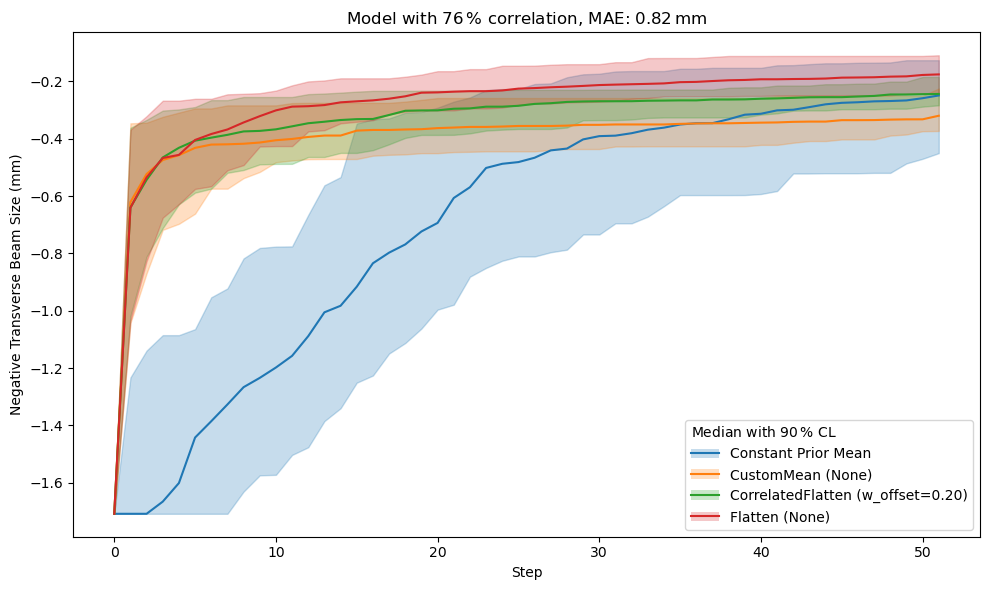

In [5]:
fig, ax = plot("data", "y");
# ax.set_ylim(-0.25, 0)
# ax.set_title("BO Performance")
# plt.tight_layout()
# fig.savefig("bo_performance.svg", facecolor='w', transparent=False)

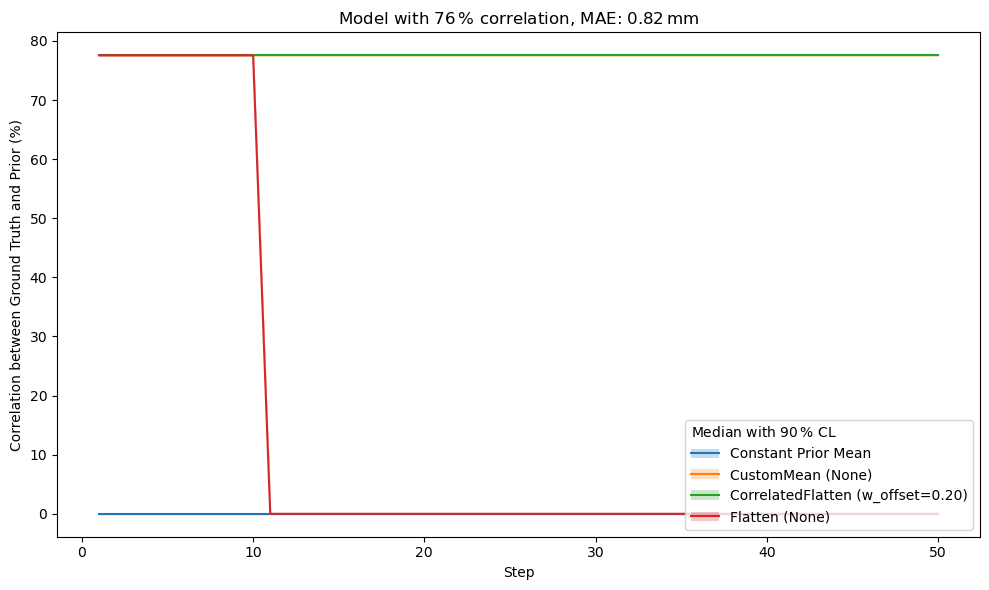

In [6]:
fig, ax = plot("metrics", "corr_prior");

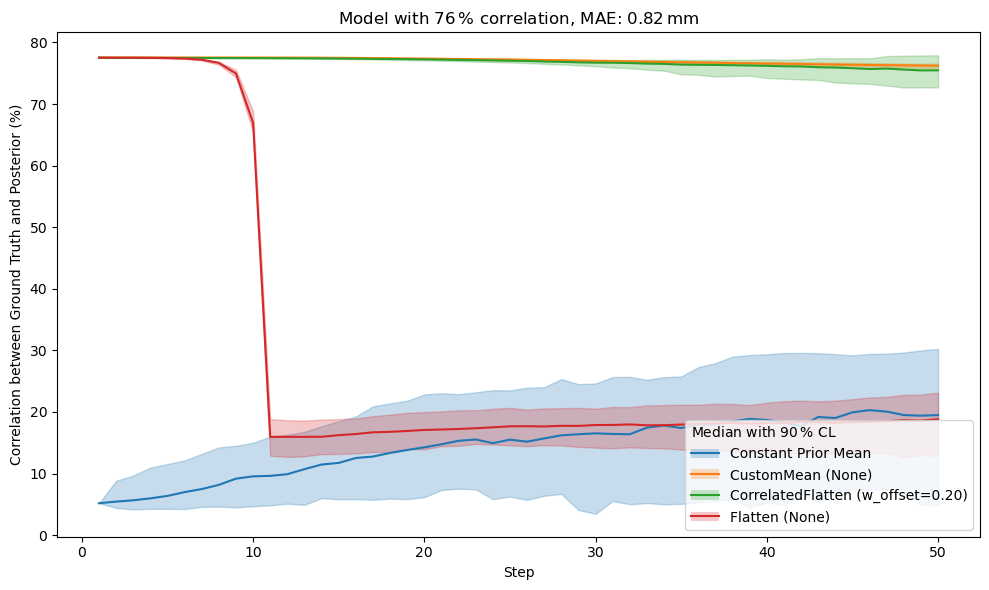

In [7]:
fig, ax = plot("metrics", "corr_posterior");

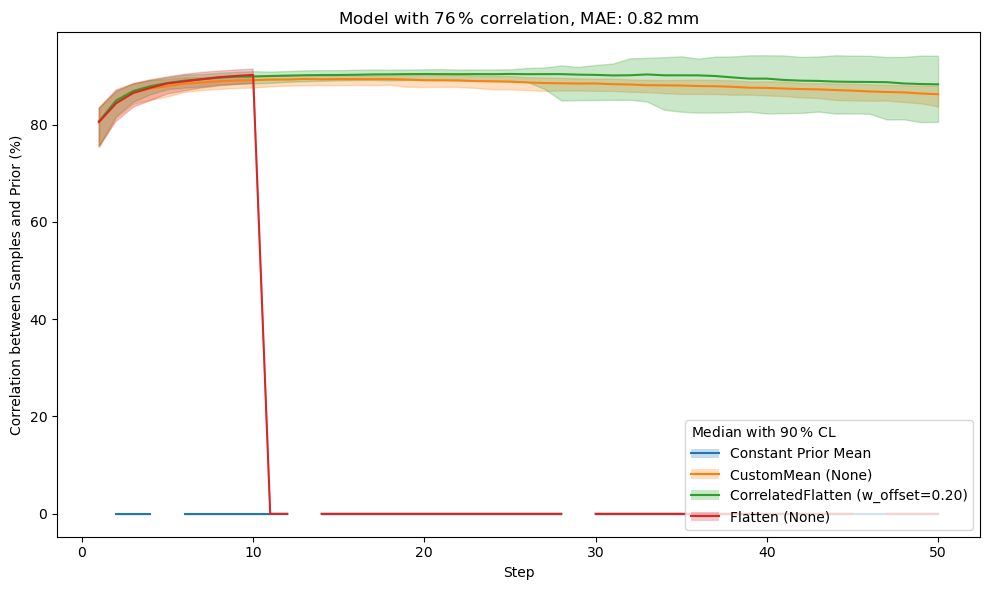

In [8]:
fig, ax = plot("metrics", "corr_samples");

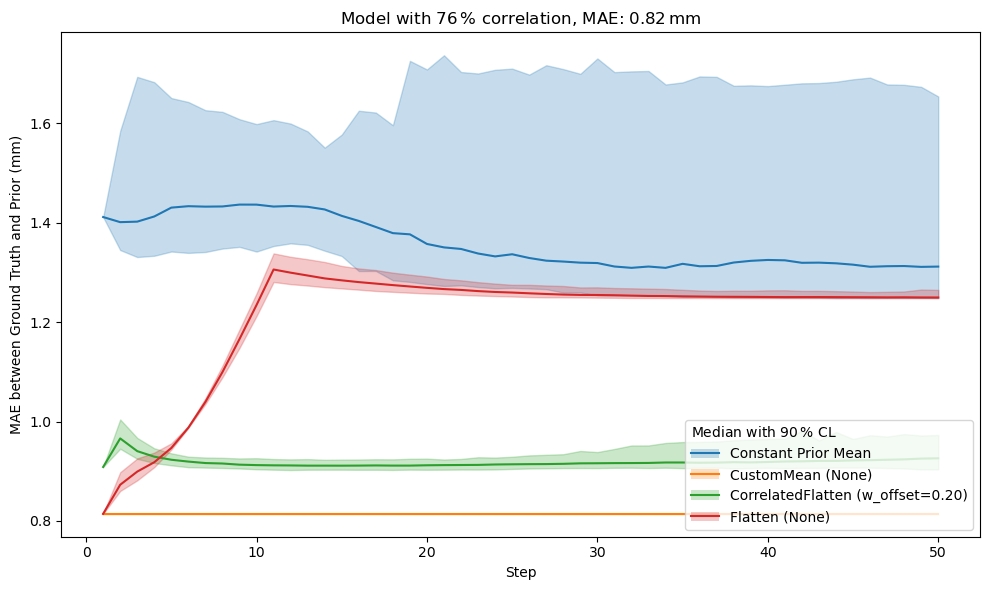

In [9]:
fig, ax = plot("metrics", "mae_prior");

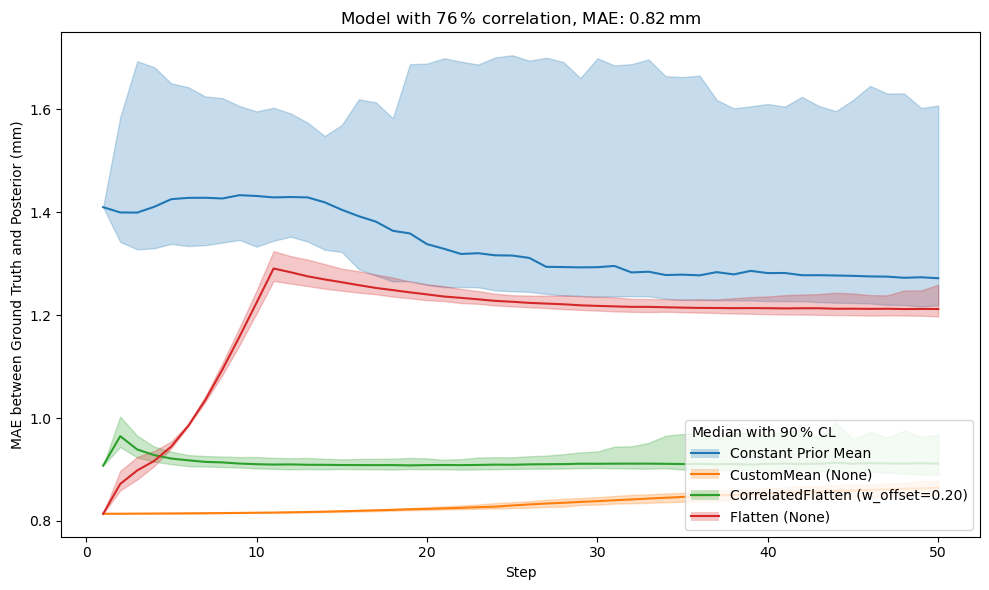

In [10]:
fig, ax = plot("metrics", "mae_posterior");

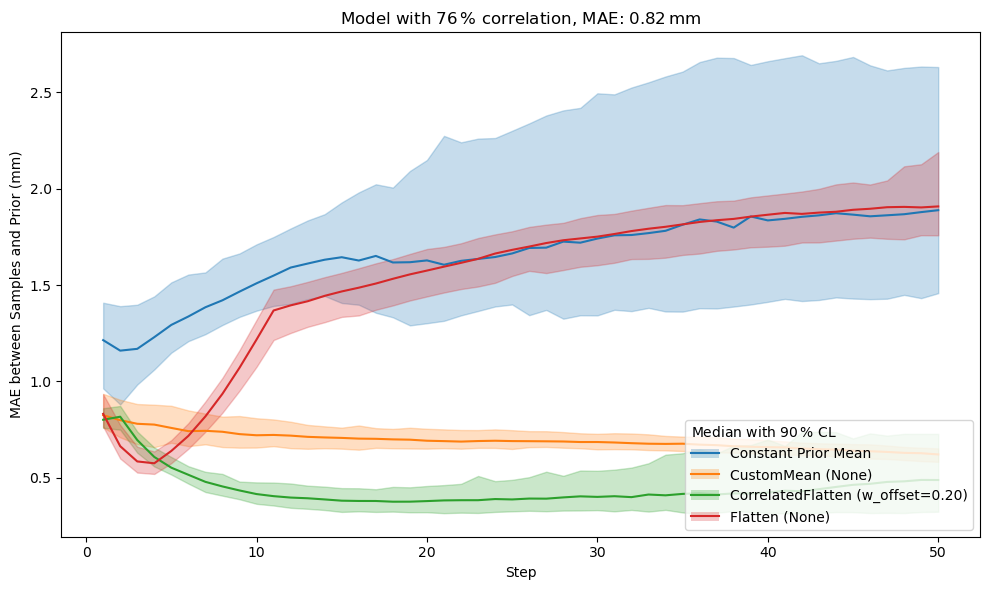

In [11]:
fig, ax = plot("metrics", "mae_samples");

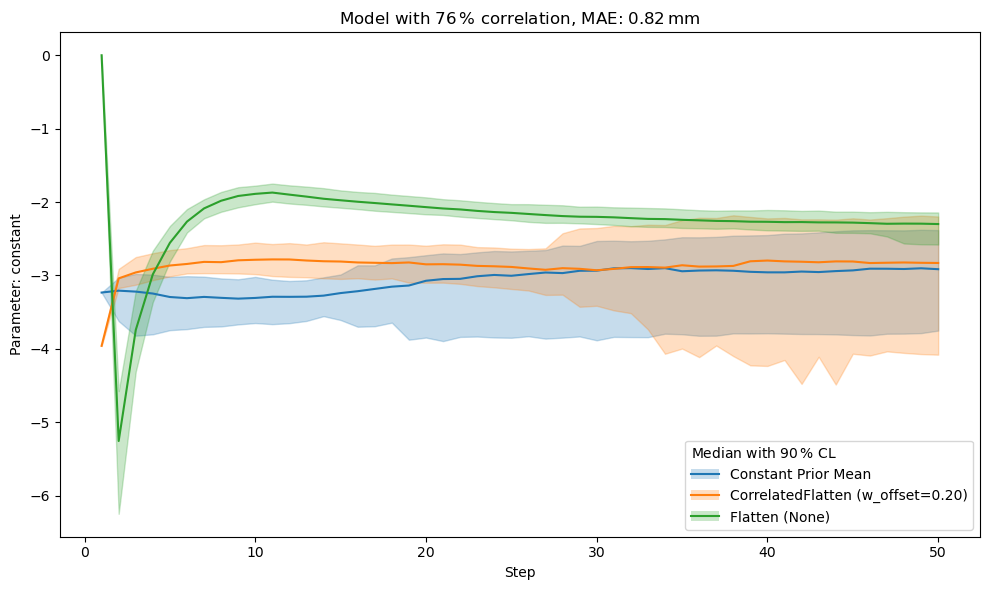

In [12]:
fig, ax = plot("mean_params", "constant");

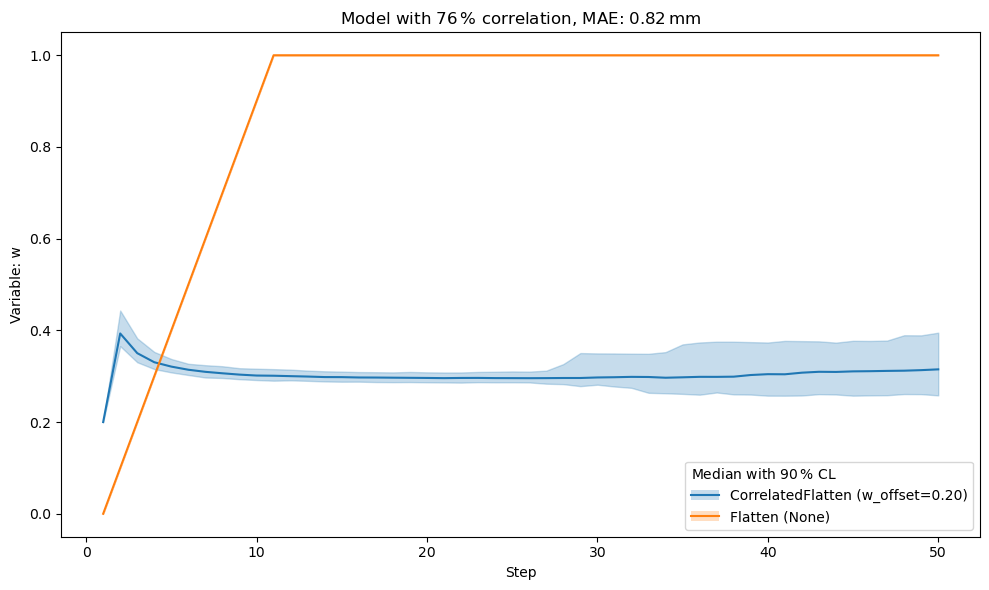

In [13]:
fig, ax = plot("mean_variables", "w");

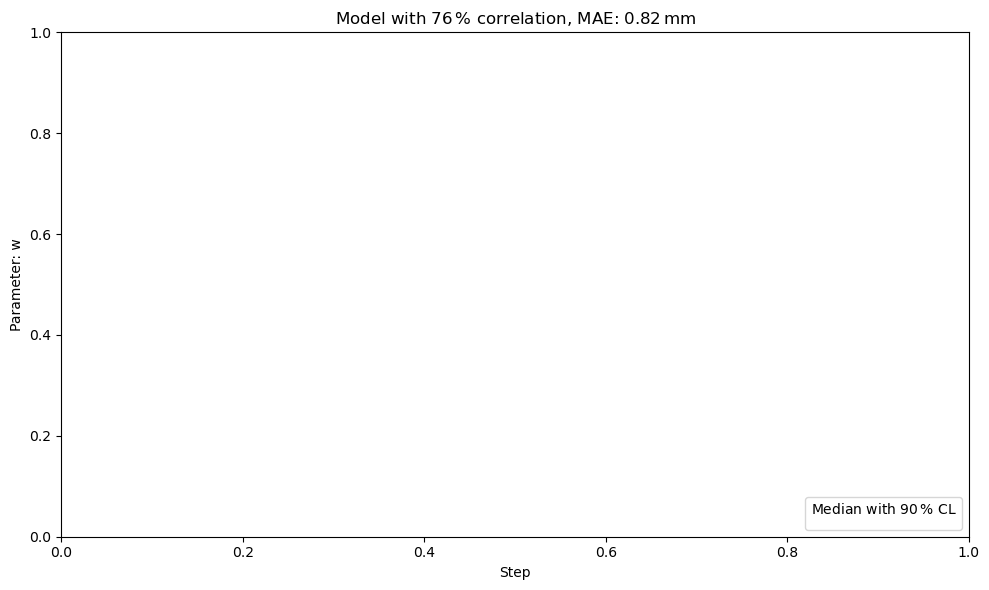

In [14]:
fig, ax = plot("mean_params", "w");